<h3>Load helper functions</h3>

In [1]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [2]:
gk_issues = load_gk_issues_for_analysis()

<h2><b>Code Changes</b></h2>

In [3]:
# commits = load_commits()
commits = load_bens_collected_commits()
commits['commit_sha'].nunique()

2044

In [4]:
# commits = load_commits()
commits = load_bens_collected_commits()
def extract_short_file_name(row):
    if row['file_name'].rfind('/') < 0:
        return row['file_name']
    return f".../{row['file_name'][row['file_name'].rfind('/')+1:]}"

commits['short_file_name'] = commits.apply(extract_short_file_name, axis=1).astype('category')

gk_commits = (
    commits[commits['issue_id']
        .isin(gk_issues['id'])]
        .reset_index(drop=True)
)
issues_with_commit = (
    gk_issues[gk_issues['id']
        .isin(gk_commits['issue_id'])]
)
print(f'{commits["commit_sha"].nunique()} commits for {len(issues_with_commit)} issues')

2044 commits for 2562 issues


In [5]:
# Used to recollect bens commits (i.e, all commits from the load_commits dataset, just with patches included)
# to_recollect_commits_for = (
#     issues_with_commit[[
#         'id',
#         'url',
#         'repo_name',
#         'dependency_name',
#         'dependency_type',
#         'dependency_actual_version',
#         'dependency_next_version',
#     ]].merge(
#         gk_commits,
#         how='inner',
#         left_on=['id'],
#         right_on=['issue_id'],
#         suffixes=['_issue', '_commit']
#     )
# )
# cols = ['repo_name', 'id', 'sha']
# to_recollect_commits_for = to_recollect_commits_for.sort_values(by=['stats_total']).copy()[cols]
# to_recollect_commits_for.rename(columns={'id': 'issue_id'})
# to_recollect_commits_for.to_csv(f'../csv/to_recollect_commits_for.csv', index=False)

In [6]:
# For collecting commits for non-gkirs
# Get repos that have GK commits
# Get all non-gk issues for these repos
# Get issue events for these issues
# Extract commit issue events
# Collect commits by sha

# repos_with_gk_commits = commits['repo_name']
# cols = ['id', 'repo_name', 'number', 'events_url']
# ngkirs_for_repos_w_gk_commits = (
#     non_gk_issues[
#         non_gk_issues['repo_name'].isin(repos_with_gk_commits)
#     ][cols].reset_index(drop=True)
# )
# ngkirs_for_repos_wo_gk_commits = (
#     non_gk_issues[
#         ~non_gk_issues['repo_name'].isin(repos_with_gk_commits)
#     ][cols].reset_index(drop=True)
# )

# ngkirs_to_collect_issue_events_for = (
#     ngkirs_for_repos_w_gk_commits
#         .append(ngkirs_for_repos_wo_gk_commits)
# )
# ngkirs_to_collect_issue_events_for.to_csv(f'../csv/ngkirs_to_collect_issue_events_for.csv', index=False)

<h3><b><i>What files are changed the most often?</i></b></h3>

Saving figure most_common_file_changes


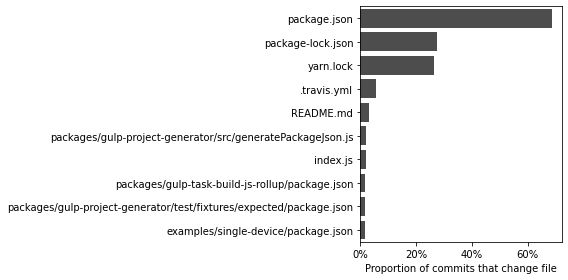

,index,file_name,count,proportion
0,0,package.json,1404,0.686888
1,69,package-lock.json,558,0.272994
2,68,yarn.lock,540,0.264188
3,95,.travis.yml,118,0.057730
4,188,README.md,61,0.029843
5,141,packages/gulp-project-generator/src/generatePackageJson.js,44,0.021526
6,92,index.js,39,0.019080
7,163,packages/gulp-task-build-js-rollup/package.json,37,0.018102
8,143,packages/gulp-project-generator/test/fixtures/expected/package.json,37,0.018102
9,140,examples/single-device/package.json,37,0.018102


In [7]:
file_counts = dict()
def record_file_counts(list_of_files):
    for f in list_of_files:
        if not f in file_counts:
            file_counts[f] = 0
        file_counts[f] += 1
gk_commits.groupby('commit_sha')['file_name'].unique().apply(record_file_counts)

count_of_file_changes = (
    pd.DataFrame({
        'file_name': file_counts.keys(),
        'count': file_counts.values(),
    })
)
count_of_file_changes['proportion'] = count_of_file_changes['count'] / gk_commits['commit_sha'].nunique()
count_of_file_changes = count_of_file_changes.sort_values('proportion', ascending=False)

UNIQUE_FILE_LIMIT = 10
most_common_files = count_of_file_changes.head(UNIQUE_FILE_LIMIT).reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
sns.barplot(
    data=most_common_files,
    y='file_name',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of commits that change file')
ax.set_ylabel('')
ax.xaxis.set_major_formatter(proportion_func_formatter)

save_fig('most_common_file_changes')
plt.show()

most_common_files

<h3>Size of changes</h3>

In [13]:
common_file_changes = (
    gk_commits[
        gk_commits['short_file_name'].isin(most_common_files['file_name'])
    ]
)
common_file_changes_simplified = (
    common_file_changes[
        ['short_file_name', 'file_changes', 'file_additions', 'file_deletions']
    ].copy()
)
common_file_changes_simplified['short_file_name'] = (
    common_file_changes_simplified['short_file_name']
        .astype(
            pd.CategoricalDtype(categories=list(most_common_files['file_name']))
        )
)
common_file_changes_simplified = (
    common_file_changes_simplified[
        common_file_changes_simplified['file_changes'] > 0
    ].copy()
)
common_file_changes_simplified.groupby('short_file_name')[['file_changes', 'file_additions', 'file_deletions']].median()

,file_changes,file_additions,file_deletions
short_file_name,,,
package.json,2.0,1.0,1.0
package-lock.json,538.0,201.0,127.0
yarn.lock,124.0,68.0,54.0
.travis.yml,3.0,1.0,2.0
index.js,5.0,2.0,1.0
README.md,13.0,9.0,4.0
generatePackageJson.js,2.0,1.0,1.0
package-conventional-changelog.json,2.0,1.0,1.0
.eslintrc.json,4.5,1.0,2.0


Saving figure most_common_file_code_churn


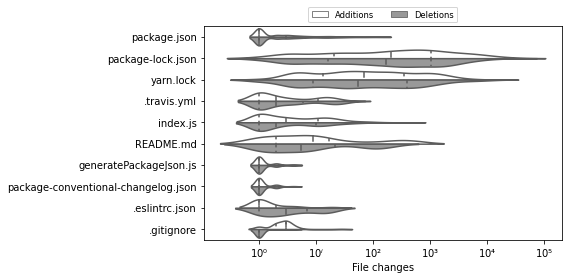

In [14]:
for_plot = common_file_changes[['short_file_name', 'file_changes', 'file_additions', 'file_deletions']].copy()
for_plot['short_file_name'] = (
    for_plot['short_file_name']
        .astype(
            pd.CategoricalDtype(categories=list(most_common_files['file_name']))
        )
)
for_plot = for_plot[for_plot['file_changes'] > 0].copy()
for_plot['log_file_changes'] = np.log10(for_plot['file_changes'])

for_plot_melted = pd.melt(
    for_plot[['short_file_name', 'file_additions', 'file_deletions']],
    id_vars=['short_file_name'],
    value_vars=['file_additions', 'file_deletions'],
    var_name='change_type',
    value_name='file_changes',
)

for_plot_melted = for_plot_melted[for_plot_melted['file_changes'] > 0].copy()
for_plot_melted['log_file_changes'] = np.log10(for_plot_melted['file_changes'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
sns.violinplot(
    data=for_plot_melted,
    x='log_file_changes',
    y='short_file_name',
    order=most_common_files['file_name'],
    hue='change_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
)
ax.set_xlabel('File changes')
ax.set_ylabel('')

ax.xaxis.set_major_formatter(log10_func_formatter)
L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.11),
    ncol=2
)

L.get_texts()[0].set_text('Additions')
L.get_texts()[1].set_text('Deletions')

save_fig('most_common_file_code_churn')

plt.show()


In [136]:
# cols = ['repo_name', 'html_url']
# gk_commits[gk_commits['short_file_name'] == 'generatePackageJson.js'][cols]

<h3>What proportion of commits reference a dependency specification file?</h3>

In [64]:
deps_spec_files = ['package.json', 'package-lock.json', 'yarn.lock', '.../package.json', '.../package-lock.json']
package_json = ['package.json']

def commit_changes_file(commit_changes, list_of_files=deps_spec_files):    
    commit_changes_for_list_of_files = (
        commit_changes[
            commit_changes['short_file_name'].isin(list_of_files)
        ]
    )
    return len(commit_changes_for_list_of_files) > 0

def commit_only_changes_files(commit_changes, list_of_files=deps_spec_files):
    count_of_file_changes = len(commit_changes)
    count_of_changes_that_change_list_of_files = (
        len(
            commit_changes[
                commit_changes['short_file_name'].isin(list_of_files)
            ]
        )
    )
    return count_of_file_changes == count_of_changes_that_change_list_of_files

commits_that_change_package_json = (
    gk_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, list_of_files=package_json))
)

commits_that_change_deps_spec_file = (
    gk_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, list_of_files=deps_spec_files))
)
commits_that_only_change_deps_spec_files = (
    gk_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, list_of_files=deps_spec_files))
)

commit_count = gk_commits['commit_sha'].nunique()
count_commits_that_change_package_json = (
    commits_that_change_package_json['commit_sha']
        .nunique()
)
count_commits_that_change_deps_spec_file = (
    commits_that_change_deps_spec_file['commit_sha']
        .nunique()
)
count_commits_that_only_change_deps_spec_files = (
    commits_that_only_change_deps_spec_files['commit_sha']
        .nunique()
)

print(f'{calculate_percent(count_commits_that_change_package_json, commit_count)}% of commits change the package.json file')
print(f'{calculate_percent(count_commits_that_change_deps_spec_file, commit_count)}% of commits change at least 1 dependency specification file')
print(f'{calculate_percent(count_commits_that_only_change_deps_spec_files, commit_count)}% of commits change only dependency specification files')

77.74% of commits change the package.json file
82.49% of commits change at least 1 dependency specification file
55.87% of commits change only dependency specification files


<h3>Specifically looking at package.json</h3>

<h4>Sizes of change to package.json (all commits)</h4>

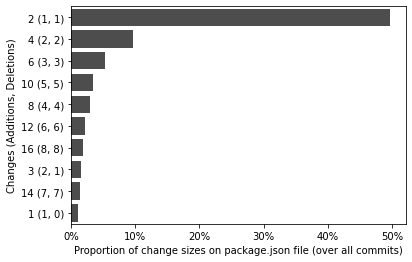

In [107]:
pj_commits = commits_that_change_package_json.copy()
pj_file_changes = pj_commits[
    pj_commits['file_name'] == 'package.json'
]
# Remove duplicates (i.e. same commit referenced from different issues)
pj_file_changes = (
    pj_file_changes
        .groupby('commit_sha')
        .first()
        .reset_index()
)
cols = ['commit_sha', 'file_additions', 'file_deletions', 'file_changes', 'html_url']
grouped_by_file_changes = pj_file_changes.groupby(['file_changes', 'file_additions', 'file_deletions'])['commit_sha']

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)

for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file (over all commits)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)

# save_fig('most_common_file_changes')
plt.show()
# for_plot.head(10)

<h4>Sizes of change to package.json (commits that only change dep spec files)</h4>

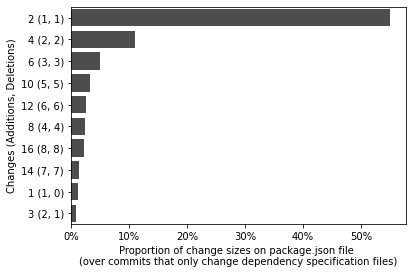

0.7102702702702703

In [132]:
pj_commits = commits_that_only_change_deps_spec_files.copy()
pj_file_changes = pj_commits[
    pj_commits['file_name'] == 'package.json'
]
# Remove duplicates (i.e. same commit referenced from different issues)
pj_file_changes = (
    pj_file_changes
        .groupby('commit_sha')
        .first()
        .reset_index()
)
cols = ['commit_sha', 'file_additions', 'file_deletions', 'file_changes', 'html_url']
grouped_by_file_changes = pj_file_changes.groupby(['file_changes', 'file_additions', 'file_deletions'])['commit_sha']

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)

for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file \n(over commits that only change dependency specification files)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)

# save_fig('most_common_file_changes')
plt.show()
# for_plot.head(3)['proportion'].sum()

<h3>How often are changes grouped?</h3>

In [143]:
package_json_changes = commits_that_change_package_json[commits_that_change_package_json['file_name'] == 'package.json']
proportions_of_issues_resolved_by_commit = (
    (   package_json_changes
            .groupby('commit_sha')['issue_id']
            .count()
            .value_counts()
    ) / (
        package_json_changes
            .groupby('commit_sha')['issue_id']
            .count()
            .value_counts()
            .sum()
    )
).reset_index(name='proportion').rename(columns={'index': 'resolved_issue_count'})
percent_resolve_more_than_1_issue = (
    proportions_of_issues_resolved_by_commit[
        proportions_of_issues_resolved_by_commit['resolved_issue_count'] > 1
    ]['proportion'].sum()
)
print(f'{percent_resolve_more_than_1_issue} of commits resolve at least 2 GKIRs')
print('Proportion of issue count resolved by commit')
# proportions_of_issues_resolved_by_commit[]

0.20512820512820512 of commits resolve at least 2 GKIRs
Proportion of issue count resolved by commit


In [146]:
import sys
!{sys.executable} -m pip install semver
import semver
import re

def extract_add_and_del_lines(patch):
    added_lines = list()
    deleted_lines = list()
    for l in patch.split('\n'):
        if len(l) < 1:
            continue
        change = l[0]
        l[1:].replace(' ', '')
        if change == '-':
            deleted_lines.append(l[1:].replace(' ', ''))
        if change == '+':
            added_lines.append(l[1:].replace(' ', ''))
    return added_lines, deleted_lines

def parse_dep_and_version(line):
    def get_val_in_between_double_quotes(v):
        try:
            result = v[v.index('"')+1:]
            result = result[0:result.index('"')]
            return result
        except Exception:
            return None
    split_line = line.split(':')
    if len(split_line) != 2:
        return None
    if not re.search('^(.?.?)\d*\.\d*\.\d*', split_line[1]):
#         print(f'Error: {split_line[1]}')
        return None
    dep = get_val_in_between_double_quotes(split_line[0])
    ver = get_val_in_between_double_quotes(split_line[1])
    return {dep: ver}

def flatten(arr):
    result = dict()
    for l in arr:
        if l:
            result[list(l.keys())[0]] = list(l.values())[0]
    return result

def merge_changes(added, deleted):
    result = dict()
    for d, v in added.items():
        if d in result:
            continue
        result[d] = {
            'package': d,
            'changed_to': {'raw': v},
            'changed_from': {'raw': deleted[d] if d in deleted else None},
        }
    for d, v in deleted.items():
        if d in result:
            continue
        result[d] = {
            'package': d,
            'changed_to': {'raw': added[d] if d in added else None},
            'changed_from': {'raw': v},
        }
    return result

def extract_range_statements(changes):
    ranges = ['^', '~', '>', '<', '<=', '<=']
    
    def extract(change, key):
        if change[key]['raw'] is None:
            change[key]['version'] = None
            change[key]['range'] = None
            return
        if change[key]['raw'][0] in ranges:
            change[key]['version'] = change[key]['raw'][1:]
            change[key]['range'] = change[key]['raw'][0:1]
        else:
            change[key]['version'] = change[key]['raw']
            change[key]['range'] = None
    for c in changes.values():
        extract(c, 'changed_from')
        extract(c, 'changed_to')
    return changes

def create_semvers(changes):
    for c in changes.values():
        if c['changed_from']['version'] is None:
            c['changed_from']['semver'] = None
        else:
            c['changed_from']['semver'] = semver.VersionInfo.parse(c['changed_from']['version'])
        if c['changed_to']['version'] is None:
            c['changed_to']['semver'] = None
        else:
            c['changed_to']['semver'] = semver.VersionInfo.parse(c['changed_to']['version'])
    return changes

def extract_change_types(changes):
    result = dict()
    def both_added_and_deleted_change(c):
        return c['changed_from']['semver'] is not None and c['changed_to']['semver'] is not None
    def add_added_or_deleted(c):
        if c['changed_from']['semver'] is None:
            c['change_types'].append('added')
        elif c['changed_to']['semver'] is None:
            c['change_types'].append('deleted')
    def add_pinned_if_necessary(c):
        if c['changed_from']['range'] and not c['changed_to']['range']:
            c['change_types'].append('pinned')
    def add_downgrade_if_necessary(c):
        if c['changed_from']['semver'] > c['changed_to']['semver']:
            c['change_types'].append('downgrade')
    def add_upgrade_if_necessary(c):
        if c['changed_from']['semver'] < c['changed_to']['semver']:
            c['change_types'].append('upgrade')
    for d, c in changes.items():
        c['change_types'] = list()
        if not both_added_and_deleted_change(c):
            add_added_or_deleted(c)
        else:
            add_pinned_if_necessary(c)
            add_downgrade_if_necessary(c)
            add_upgrade_if_necessary(c)
    return changes

def simplify(changes):
    result = list()
    for _, c in changes.items():
        result.append({
            'package': c['package'],
            'changed_from': c['changed_from']['raw'],
            'changed_to': c['changed_to']['raw'],
            'changes_types': c['change_types']
        })
    return result

def flatten_simplified(simplified):
    result = list()
    for s in simplified:
        for t in s['changes_types']:
            result.append({
                'package': s['package'],
                'changed_from': s['changed_from'],
                'changed_to': s['changed_to'],
                'change_type': t
            })
    return result

def add_commit_info(simplified, commit):
    result = list()
    for s in simplified:
        result.append({
            'commit_sha': commit['commit_sha'],
            'issue_id': commit['issue_id'],
            'package': s['package'],
            'changed_from': s['changed_from'],
            'changed_to': s['changed_to'],
            'change_type': s['change_type'],
        })
    return result

def package_json_change_pipeline(commit):
    try:
        added_lines, deleted_lines = extract_add_and_del_lines(commit['file_patch'])
        add_dep_changes = flatten([parse_dep_and_version(l) for l in added_lines])        
        del_dep_changes = flatten([parse_dep_and_version(l) for l in deleted_lines])
#         print(add_dep_changes)
#         print(del_dep_changes)
        changes = merge_changes(add_dep_changes, del_dep_changes)
#         print(changes)
        changes = extract_range_statements(changes)
#         print(changes)
        changes = create_semvers(changes)
        changes = extract_change_types(changes)
        simplified = simplify(changes)
#         print(simplified)
        simplified = flatten_simplified(simplified)
        simplified = add_commit_info(simplified, commit)
        return simplified
    except Exception as e:
        print('error:', e)
        pass

unique_package_json_changes = package_json_changes.groupby('commit_sha').first().reset_index()
# change_types = unique_package_json_changes.head(16).tail(1).apply(package_json_change_pipeline, axis=1)
change_types = unique_package_json_changes.apply(package_json_change_pipeline, axis=1)

for_df = {
    'commit_sha': list(),
    'issue_id': list(),
    'package': list(),
    'changed_from': list(),
    'changed_to': list(),
    'change_type': list(),
}

for c in change_types:
    if not c:
        continue
    for x in c:
        for_df['commit_sha'].append(x['commit_sha'])
        for_df['issue_id'].append(x['issue_id'])
        for_df['package'].append(x['package'])
        for_df['changed_from'].append(x['changed_from'])
        for_df['changed_to'].append(x['changed_to'])
        for_df['change_type'].append(x['change_type'])
change_types = pd.DataFrame(for_df)
change_types

  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
error: 1.16.x is not valid SemVer string
error: 6.2.0||~6.2.1 is not valid SemVer string
error: 2.17.1&&<2.18.0 is not valid SemVer string


,commit_sha,issue_id,package,changed_from,changed_to,change_type
0,00140fef447691c1e805b3a542e5c6dba9c9589c,394593144,gatsby,^2.0.67,^2.0.80,upgrade
1,00140fef447691c1e805b3a542e5c6dba9c9589c,394593144,gatsby-plugin-favicon,^3.1.4,^3.1.5,upgrade
2,00140fef447691c1e805b3a542e5c6dba9c9589c,394593144,gatsby-plugin-offline,^2.0.19,^2.0.20,upgrade
3,00140fef447691c1e805b3a542e5c6dba9c9589c,394593144,gatsby-plugin-react-helmet,^3.0.4,^3.0.5,upgrade
4,00140fef447691c1e805b3a542e5c6dba9c9589c,394593144,gatsby-plugin-sharp,^2.0.15,^2.0.17,upgrade
...,...,...,...,...,...,...
5446,ff686a8e81771af2f75baf8eac977886f855821a,459855347,eslint-config-airbnb,^17.1.0,^18.0.1,upgrade
5447,ff686a8e81771af2f75baf8eac977886f855821a,459855347,eslint-plugin-react,^7.11.1,^7.14.3,upgrade
5448,ff686a8e81771af2f75baf8eac977886f855821a,459855347,eslint-plugin-react-hooks,None,^1.7.0,added
5449,ff807acd28c7f63944cb52065a3708da57247cba,208733229,decaffeinate-parser,^16.0.5,^16.0.7,upgrade


<h3>What are the change types?</h3>

In [147]:
temp = (
    change_types.groupby('commit_sha')['change_type']
        .value_counts()
        .to_frame(name='count')
        .reset_index()
)
temp['change_type'].value_counts() / temp['change_type'].value_counts().sum()

upgrade      0.802924
added        0.065480
deleted      0.061030
pinned       0.048951
downgrade    0.021615
Name: change_type, dtype: float64

<h3>How often are changes grouped together?</h3>

In [148]:
commit_change_types = (
    change_types
        .groupby('commit_sha')['change_type']
        .value_counts()
        .to_frame(name='count')
        .reset_index()
)
commit_change_types
tfns(
    commit_change_types[commit_change_types['change_type'] == 'upgrade'],
    ['count']
)


         Count    Mean    STD    Min    25%    Median    75%    Max
-----  -------  ------  -----  -----  -----  --------  -----  -----
count     1263     3.8  5.502      1      1         1      4     36



<h3>Can we tell when clients take the GK pin approach?</h3>

In [176]:


# gk_authored_commits = pj_file_changes[pj_file_changes['author_login'] == 'greenkeeper[bot]']
gk_authored_commits = (
    commits[
        commits['author_login'] == 'greenkeeper[bot]'
    ]
)
# gk_authored_commits.info()
# gk_authored_commits[['commit_sha', 'author_login', 'stats_total']]['stats_total'].describe()

change_types.loc[
    (change_types['commit_sha'].isin(gk_authored_commits['commit_sha'])) &
    (change_types['change_type'] == 'pinned')
]

,commit_sha,issue_id,package,changed_from,changed_to,change_type
2694,7db245420c655dae845475ffde9d30a892b2b910,482049093,eslint,^6.1.0,6.1.0,pinned
4488,d1ec9797bf77fc78496a6d00cc68c088d120abc8,531505237,@types/react-dom,^16.9.4,16.9.4,pinned
4721,decad4a046ea7a09836d1903ecd8459cf47a1f42,234992050,codeclimate-test-reporter,^0.4.1,0.5.0,pinned
5023,ee7bc3e18dd69baf1bd91303900c674ef76e76c2,482049093,eslint,^6.1.0,6.1.0,pinned


In [178]:
commits[commits['commit_sha'] == '7db245420c655dae845475ffde9d30a892b2b910']['html_url']

173    https://github.com/sharvit/generator-node-mdl/commit/7db245420c655dae845475ffde9d30a892b2b910
174    https://github.com/sharvit/generator-node-mdl/commit/7db245420c655dae845475ffde9d30a892b2b910
Name: html_url, dtype: object